# Part I. One-sided finite differences

Write a function, `deriv`, which computes a derivative of its argument at a given point, $x$, using a one-sided finite difference rule with a given step side $h$, with the approximation order of $O(h^2)$. 

In [31]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [32]:
def deriv(f, x, h):
    """ Compute a derivative of `f` at point `x` with step size `h`.
    
    Compute the derivative using the one-sided rule of the approximation order of $O(h^2)$.
    
    Parameters
    ----------
    f : callable
        The function to differentiate
    x : float
        The point to compute the derivative at.
    h : float
        The step size for the finite different rule.
        
    Returns
    -------
    fder : derivative of f(x) at point x using the step size h.
    """
    return (- 3 / 2  * f(x) + 2 * f(x + h) - 1 / 2 * f(x + 2 * h)) / h

#### Test I.1

Test your function on a simple test case: differentiate $f(x) = x^3$ at $x=0$. Comment on whether your results are consistent with the expected value of $f'(x) = 0$ and on an expected scaling with $h\to 0$.

 (10% of the total grade)

In [33]:
x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(lambda x: x**3, x, h)
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.0002
0.001000 --  -2e-06
0.000100 --  -2e-08
0.000010 --  -2e-10


С уменьшением шага $h$ точность подсчета производной увеличивается как квадрат (т.е. при шаге 1e-2 точность составляет 1e-4 и т.д.). Исходя из этого предполагаем, что результаты устойчивы.

### Test I.2

Now use a slightly more complicated function, $f(x) = x^2 \log{x}$, evaluate the derivative at $x=1$ using your one-sided rule and a two-point one-sided rule. Roughly estimate the value of $h$ where the error stops decreasing, for these two schemes. 
(15% of the total grade)

In [34]:
from math import log

def f(x):
    return x**2 * log(x)
    
def fder(x):
    return x * (2.*log(x) + 1)

In [35]:
def deriv_2pt(f, x, h):
    return (f(x + h) - f(x)) / h

In [36]:
h_arr = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]

In [37]:
x = 1
difference_deriv = []
difference_deriv_2pt = []
for h in h_arr:
    difference_deriv.append(abs(fder(x) - deriv(f, x, h)))
    difference_deriv_2pt.append(abs(fder(x) - deriv_2pt(f, x, h)))

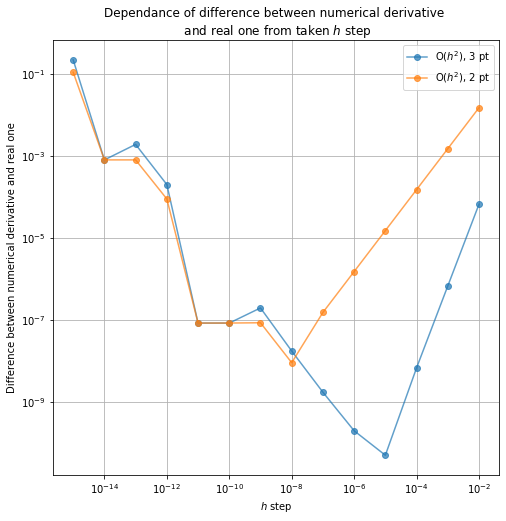

In [38]:
# Add labels ffs.

plt.figure(figsize=(8, 8))

plt.plot(h_arr, difference_deriv, 'o-', alpha=0.7, label='O($h^2$), 3 pt', color='C0')

plt.plot(h_arr, difference_deriv_2pt, 'o-', alpha=0.7, label='O($h^2$), 2 pt', color='C1')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$h$ step')
plt.ylabel('Difference between numerical derivative and real one')

plt.title('Dependance of difference between numerical derivative \n and real one from taken $h$ step')

plt.grid()

plt.legend()


plt.show()

Минимальные значения достигаются при $h = 10^{-8}$ и $h = 10^{-3}$ для каждого алгоритма соответственно. 

### Test I.3 

Now try differentiating $x^2 \log(x)$ at $x=0$. Use the three-point one-sided rule. Note that to evaluate the function at zero, you need to special-case this value. Check the scaling of the error with $h$, explain your results. 
(25% of the total grade)

In [39]:
def f(x):
    if x == 0:
        # the limit of $x^2 log(x)$ at $x-> 0$ is zero, even though log(x) is undefined at x=0
        return 0.0
    else:
        return x**2 * log(x)
    
def fder(x):
    if x == 0:
        return 0.0
    else:
        return x*(2*log(x) + 1)

x = 0
for h in [1e-2, 1e-3, 1e-4, 1e-5]:
    err = deriv(f, x, h) - fder(x)
    print("%5f -- %7.4g" % (h, err))

0.010000 -- -0.01386
0.001000 -- -0.001386
0.000100 -- -0.0001386
0.000010 -- -1.386e-05


Сходимость в этот раз оказывается линейной, а не квадратично, как в первом пункте. Связано это по всей видимости с тем, что остаточный член получается из третьей производной, которая в нашем случае оказывается пропорциональной $x^{-1}$. Поэтому логично, что теперь мы сходимся не как $h^2$, а как $h$.

# Part II. Midpoint rule 

Write a function which computes a definite integral using the midpoint rule up to a given error, $\epsilon$. Estimate the error by comparing the estimates of the integral at $N$ and $2N$ elementary intervals. 

In [40]:
def midpoint_rule(func, a, b, eps):
    """ Calculate the integral of f from a to b using the midpoint rule.
    
    Parameters
    ----------
    func : callable
        The function to integrate.
    a : float
        The lower limit of integration.
    b : float
        The upper limit of integration.
    eps : float
        The target accuracy of the estimate.
        
    Returns
    -------
    integral : float
        The estimate of $\int_a^b f(x) dx$.
    """
    Q_old = func((a + b) / 2) * (b - a)
    nof_dots_coef = 2

    while True:
        dots = np.linspace(a, b, 2 ** nof_dots_coef)
        step = dots[1] - dots[0]
        int_points = (dots[:-1] + dots[1:]) / 2
        Q_new = np.sum(func(int_points) * step)
        if (abs(Q_new - Q_old) < eps):
            return Q_old
        else:
            Q_old = Q_new
            nof_dots_coef += 1


def midpoint_rule_test(func, a, b, eps):
    
    Q_old = func((a + b) / 2) * (b - a)
    nof_dots_coef = 2
    Q_array = np.array(Q_old)

    while True:
        dots = np.linspace(a, b, 2 ** nof_dots_coef)
        step = dots[1] - dots[0]
        int_points = (dots[:-1] + dots[1:]) / 2
        Q_new = np.sum(func(int_points) * step)
        if (abs(Q_new - Q_old) < eps):
            return Q_new, 2 ** np.arange(1, nof_dots_coef), Q_array
        else:
            Q_old = Q_new
            nof_dots_coef += 1
            Q_array = np.append(Q_array, Q_old)

### Test II.1

Test your midpoint rule on a simple integral, which you can calculate by paper and pencil.

Compare the rate of convergence to the expected $O(N^{-2})$ scaling by studying the number of intervals required for a given accuracy $\epsilon$.

Compare the numerical results to the value you calculated by hand. Does the deviation agree with your estimate of the numerical error?
(20% of the total grade)


In [41]:
def fit_func(x, a):
    return a / x / x

def F(x):
    return 1 / x

def f(x):
    return -1 / (x ** 2)

Integral, dots_arr, Int_array = midpoint_rule_test(f, 1, 2, 1e-10)
error = np.abs(Int_array - F(2) + F(1))

par, _ = curve_fit(fit_func, dots_arr, error)

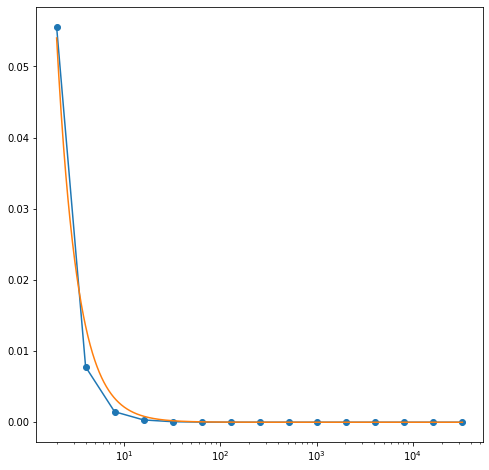

In [42]:
plt.figure(figsize=(8, 8))
plt.plot(dots_arr, error, 'o-')
x_grid = np.linspace(dots_arr[0], dots_arr[-1], int(1e6))
plt.plot(x_grid, fit_func(x_grid, par), '-')
plt.xscale('log')
plt.show()

Вроде похоже на $1 / x ^ 2$.

### Test II.2

Now use your midpoint rule to compute the value of

$$
\int_0^1\! \frac{\sin{\sqrt{x}}}{x}\, dx
$$

up to a predefined accuracy of $\epsilon=10^{-4}$.

Note that the integral contains an integrable singularity at the lower limit. Do calculations two ways: first, do a straightforward computation; next, subtract the singularity. Compare the number of iterations required to achieve the accuracy of $\epsilon$.

(30% of the total grade)

In [43]:
def f(x):
    return np.sin(np.sqrt(x)) / x

def f_enh(x):
    return f(x) - 1 / np.sqrt(x)

In [44]:
straight, iterations, _ = midpoint_rule_test(f, 0, 1, 1e-4)
substracted, iterations_sub, _ = midpoint_rule_test(f_enh, 0, 1, 1e-4)
substracted += 2 # +2 is from integrating 1 / sqrt(x)

print('Straightforward: {:.4f}, took {} steps'.format(straight, len(iterations)))
print('Substracted: {:.4f}, took {} steps'.format(substracted, len(iterations_sub)))

Straightforward: 1.8920, took 22 steps
Substracted: 1.8921, took 5 steps


Видно, что с вычитанием сингулярности работает нормально. Кто ж знал. И итераций даже меньше требует.